# Import Required Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader, ConcatDataset

# Load Dataset

In [ ]:
transforms_ = transforms.Compose([
    transforms.Resize([14,14]),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])
train_set = datasets.MNIST( download=True,  root="./",  transform=transforms_ ,train=True)
test_set = datasets.MNIST(download=True, root="./", transform=transforms_, train=False)
full_set = ConcatDataset([train_set, test_set])
train_loader = DataLoader(full_set, batch_size=64, shuffle=False)

# Define Diffusion Model, Loss Function And Optimizer

In [7]:
class ResLayer(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm1d(128),
            nn.Linear(128, in_features),
            nn.LeakyReLU(0.2, True),
        )

    def forward(self, x):
        return self.layer(x) + x
    

class Diffusion(nn.Module):
    def __init__(self, beta_start=1e-4, beta_end=2e-2, num_forward_steps=1000, device='cuda'):
        super().__init__()
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.num_forward_steps = num_forward_steps
        self.device = device
        self.model = nn.Sequential(
                    nn.Linear(196 + num_forward_steps + 10, 512),
                    ResLayer(512),
                    nn.Linear(512, 512),
                    ResLayer(512),
                    nn.Linear(512, 512),
                    ResLayer(512),
                    nn.Linear(512, 196)
                ).to(device)
        beta = torch.linspace(self.beta_start, self.beta_end, self.num_forward_steps).numpy().tolist()
        self.beta = torch.tensor(beta).to(self.device)
        alpha = [1 - beta[0]]
        for i in range(1, self.num_forward_steps):
            alpha.append(alpha[i-1] * (1 - beta[i]))
        self.alpha = torch.tensor(alpha).to(device)

    def forward_process(self, image):
        alpha = self.alpha.repeat(*image.shape, 1).permute(-1, *[i for i in range(len(image.shape))]).to(self.device)
        noise = torch.randn_like(alpha)
        noisy_image = alpha.sqrt() * image +  (1 - alpha).sqrt() * noise
        return noisy_image, noise

    def backward_process(self, noisy_image, label):
        batch_size = noisy_image.shape[1]
        pred_noise = Variable(torch.zeros(self.num_forward_steps, batch_size, 1, 14, 14).to(self.device))
        for t in range(self.num_forward_steps-1, -1, -1):
            noisy_image_batch = noisy_image[t].reshape(batch_size, -1)
            time_one_hot = torch.zeros(batch_size, self.num_forward_steps).to(self.device)
            time_one_hot[:, t] = 1
            noisy_image_batch_with_time = torch.concatenate([noisy_image_batch, time_one_hot, one_hot(label, 10)], dim=1)
            noise_batch = self.model(noisy_image_batch_with_time).view(batch_size, 1, 14, 14)
            pred_noise[t] = noise_batch
        return pred_noise

    def generate(self, label, middle_noise=False):
        image = torch.randn(label.shape[0], 196).to(self.device)
        for t in range(self.num_forward_steps-1, -1, -1):
            time_one_hot = torch.zeros(label.shape[0], self.num_forward_steps).to(self.device)
            image_with_time = torch.concatenate([image, time_one_hot, one_hot(label, 10)], dim=1)
            noise_pred = self.model(image_with_time)
            if middle_noise:
                if t == 0:
                    noise = torch.zeros_like(image)
                else:
                    noise = torch.randn_like(image)
                image = (1 / (1 - self.beta[t]).sqrt()) * (image - ((self.beta[t]) / (1 - self.alpha[t]).sqrt()) * noise_pred) + self.beta[t] * noise
            else:
                image = (1 / (1 - self.beta[t]).sqrt()) * (image - ((self.beta[t]) / (1 - self.alpha[t]).sqrt()) * noise_pred)
        return image.view(label.shape[0], 1, 14, 14)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
diffusion = Diffusion(1e-3, 7e-1, 20)
diffusion.load_state_dict(torch.load('diffusion.pth', map_location='cuda'))
criterion = nn.MSELoss()
optimizer = optim.AdamW(diffusion.parameters(), lr=5e-4)

C:\Users\meysam\AppData\Local\Temp\ipykernel_14500\1746156000.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diffusion.load_state_dict(torch.load('diffusion.pth', map_

# Train Diffusion

In [ ]:
for epoch in range(120):
    total_loss = []
    for i, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
        noisy_image, noise = diffusion.forward_process(data)
        pred_noise = diffusion.backward_process(noisy_image, label)
        loss = criterion(noise, pred_noise)
        total_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'epoch {epoch+1}      total {np.mean(total_loss)}')


# Generate Results

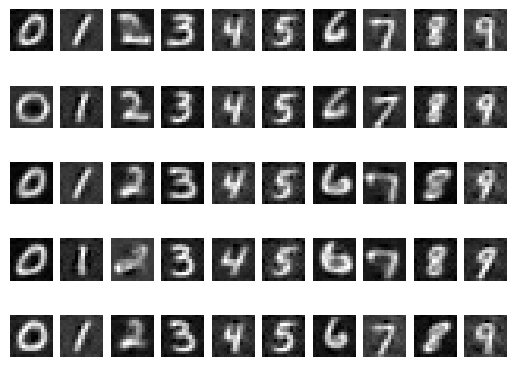

In [13]:
labels = torch.concatenate([torch.linspace(0, 9, 10).type(torch.LongTensor) for _ in range(5)]).to(device)
images = diffusion.generate(labels)

plt.figure()
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(images[i].detach().cpu().numpy().reshape(14,14), cmap='gray')
    plt.axis('off')
plt.show()